In [1]:
import os
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

from Tusc5ImageUtils import *
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import exposure
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, plot, models, denoise
from scipy.ndimage import binary_erosion, binary_fill_holes, center_of_mass
import subprocess
import pandas as pd
import nd2
from skimage.measure import regionprops

Current Working Directory: /Users/raphaeltinio/Lab Analysis MAC/ImageAnalysis


In [2]:
### Directory Configuration ###

parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_directory = os.path.join(parent_directory, 'Test Stacks')

model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V3')
img_path = os.path.join(test_stacks_directory, '2007R_GLUT1_647_WGA_594_0002.nd2')

In [3]:
### Image Insertion ###
f = nd2.ND2File(img_path)
image = to_8bit(f.asarray())

DAPI_stack = image[:,0,:,:].copy()
eGFP_stack = image[:,1,:,:].copy()
WGA_stack = image[:,2,:,:].copy()

mp_DAPI = max_proj(DAPI_stack)
model = models.CellposeModel(pretrained_model=model_path_dapi)
DAPI_masks, flows, styles = model.eval(mp_DAPI, diameter=90, channels=[0,0])

In [4]:
# 1) Finding coordinates of cells
coords_3d = nuclei_centers_of_mass(DAPI_stack, DAPI_masks)

# 2) Removing local outliers from mask
filtered_coords_3d, filtered_idxs = remove_outliers_local(coords_3d)
DAPI_masks = extract_masks(DAPI_masks, filtered_idxs)


# Removing local outliers

/Users/raphaeltinio/opt/anaconda3/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:1535: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


(-0.5, 1023.5, 1023.5, -0.5)

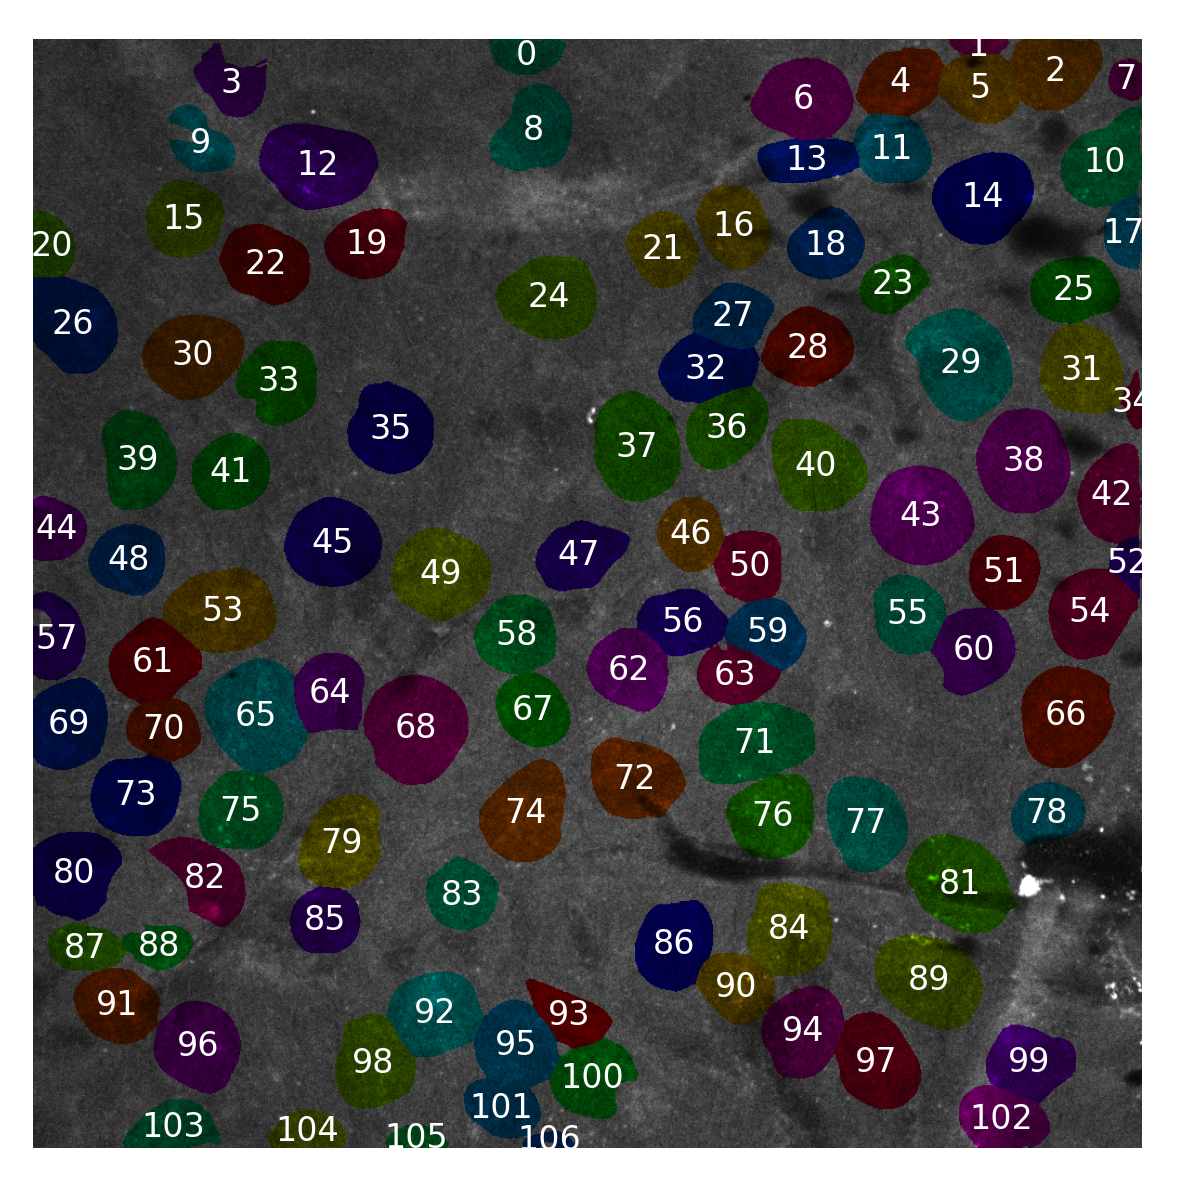

In [13]:
nuclei_zs = nuclei_slices(DAPI_stack, DAPI_masks)
z_intensities = np.sum(WGA_stack, axis=(1, 2))
ILM_layer = int(np.argmax(z_intensities))
nuclei_layer = np.sum(nuclei_zs) // len(nuclei_zs)
vein_axon_layer = int((ILM_layer + nuclei_layer) / 2)

overlay = plot.mask_overlay(WGA_stack[ILM_layer, :, :], DAPI_masks)

plt.imshow(overlay)
plot_maskids(get_nuclei_position(DAPI_masks), text_color= 'white', font_size= 8)
plt.axis('off')


In [22]:
import tkinter as tk

class NumberInputApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Fast Number Input")
        
        self.input_var = tk.StringVar()
        self.input_list = []

        self.create_widgets()
        self.bind_keys()

    def create_widgets(self):
        # Create an Entry widget to display the input
        self.entry = tk.Entry(self.root, textvariable=self.input_var, font=('Helvetica', 24), justify='center')
        self.entry.grid(row=0, column=0, columnspan=3)

        # Create number buttons
        self.buttons = []
        for i in range(1, 10):
            button = tk.Button(self.root, text=str(i), font=('Helvetica', 24), command=lambda i=i: self.on_button_click(i))
            self.buttons.append(button)

        # Arrange buttons in a grid
        for i in range(1, 10):
            self.buttons[i-1].grid(row=(i-1)//3 + 1, column=(i-1)%3)

        # Create Clear and Submit buttons
        self.clear_button = tk.Button(self.root, text="Clear", font=('Helvetica', 24), command=self.clear_input)
        self.clear_button.grid(row=4, column=0)

        self.submit_button = tk.Button(self.root, text="Submit", font=('Helvetica', 24), command=self.submit_input)
        self.submit_button.grid(row=4, column=2)

    def bind_keys(self):
        for i in range(1, 10):
            self.root.bind(str(i), self.on_key_press)
        self.root.bind('<Return>', self.submit_input)
        self.root.bind('<BackSpace>', self.on_backspace_press)

    def on_button_click(self, number):
        current_value = self.input_var.get()
        self.input_var.set(current_value + str(number))

    def on_key_press(self, event):
        current_value = self.input_var.get()
        self.input_var.set(current_value + event.char)

    def on_backspace_press(self, event):
        current_value = self.input_var.get()
        self.input_var.set(current_value[:-1])

    def clear_input(self):
        self.input_var.set("")

    def submit_input(self, event=None):
        input_value = self.input_var.get()
        if input_value:
            self.input_list.append(input_value)
            print("User input:", input_value)
            self.clear_input()

# Create the main window
root = tk.Tk()
app = NumberInputApp(root)

# Run the main event loop
root.mainloop()

# Print the collected inputs after the window is closed
print("Collected inputs:", app.input_list)

User input: 12
Collected inputs: ['12']
